In [1]:
import torch.nn as nn

In [2]:
conv = nn.Conv2d(3,16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [3]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [4]:
import torch

In [5]:
torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
import torch.optim as optim

In [6]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [7]:
from torchvision import datasets, transforms

data_path = './unversioned_data/cifar/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
]))

Files already downloaded and verified


In [8]:
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
]))

Files already downloaded and verified


In [9]:
label_map = {0:0, 2:1}
class_names = ['airplane','bird']

cifar2 = [(img, label_map[label]) for img,label in cifar10 if label in [0,2]]
cifar2_val = [(img,label_map[label]) for img,label in cifar10_val if label in [0,2]]

In [10]:
img,_ = cifar2[0]
output = conv(img.unsqueeze(0))
output.shape, img.unsqueeze(0).shape

(torch.Size([1, 16, 30, 30]), torch.Size([1, 3, 32, 32]))

In [11]:
import matplotlib.pyplot as plt

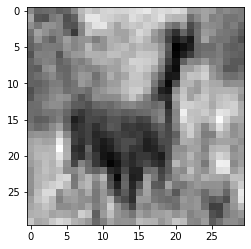

In [12]:
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()

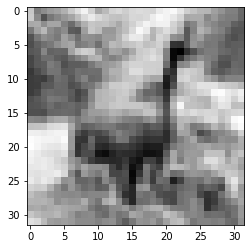

In [13]:
plt.imshow(img[0].detach(),cmap='gray')
plt.show()

In [14]:
conv = nn.Conv2d(3,1,kernel_size=3,padding=1)
output = conv(img.unsqueeze(0))
output.shape

torch.Size([1, 1, 32, 32])

In [15]:
with torch.no_grad():
    conv.bias.zero_()
with torch.no_grad():
    conv.weight.fill_(1.0/9.0)

In [16]:
output = conv(img.unsqueeze(0))
output.shape

torch.Size([1, 1, 32, 32])

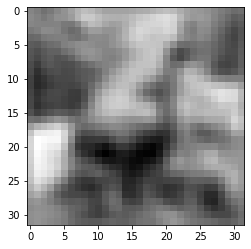

In [17]:
plt.imshow(output[0,0].detach(),cmap='gray')
plt.show()

In [18]:
conv = nn.Conv2d(3,1,kernel_size=3,padding=1)
with torch.no_grad():
    conv.weight[:]=torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]])
    conv.bias.zero_()

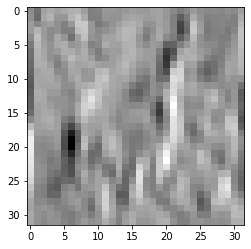

In [19]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(),cmap='gray')
plt.show()

In [20]:
model = nn.Sequential(
    nn.Conv2d(3,16,kernel_size=3,padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16,8,kernel_size=3,padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(8*8*8,32),
    nn.Tanh(),
    nn.Linear(32,2)
)

In [21]:
num_list=  [p.numel() for p in model.parameters()]
sum(num_list),num_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [22]:
model(img.unsqueeze(0))

tensor([[-0.0747, -0.1468]], grad_fn=<AddmmBackward0>)

In [23]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16,8,kernel_size=3,padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8,32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32,2)
    def forward(self,x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1,8*8*8)
        out = self.fc2(self.act3(self.fc1(out)))
        return out

In [24]:
model = Net()

In [25]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [26]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(16,8,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(8*8*8,32)
        self.fc2 = nn.Linear(32,2)
    def forward(self,x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1,8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [27]:
model = Net()


In [28]:
model(img.unsqueeze(0))

tensor([[0.1819, 0.2055]], grad_fn=<AddmmBackward0>)

In [29]:
import datetime

def training_loop(n_epochs,optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train+=loss.item()
        if epoch==1 or epoch%10==0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train/len(train_loader)))

In [30]:
train_loader = torch.utils.data.DataLoader(cifar2,batch_size=64,shuffle=True)

In [31]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(100,optimizer,model,loss_fn,train_loader)

2022-06-07 09:11:47.759427 Epoch 1, Training loss 0.5901459776292182
2022-06-07 09:12:19.456675 Epoch 10, Training loss 0.34008024281756893
2022-06-07 09:12:53.771394 Epoch 20, Training loss 0.2979670995075232
2022-06-07 09:13:29.130203 Epoch 30, Training loss 0.2746125029720319
2022-06-07 09:14:03.888243 Epoch 40, Training loss 0.25680380276623804
2022-06-07 09:14:39.594577 Epoch 50, Training loss 0.23310274578583468
2022-06-07 09:15:12.509016 Epoch 60, Training loss 0.21696457660691754
2022-06-07 09:15:44.371948 Epoch 70, Training loss 0.19908252154376097
2022-06-07 09:16:16.942340 Epoch 80, Training loss 0.18509348021571043
2022-06-07 09:16:51.899246 Epoch 90, Training loss 0.17014664957287964
2022-06-07 09:17:25.854431 Epoch 100, Training loss 0.1574175834987953


In [32]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,shuffle=False)

In [33]:
def validate(model, train_loader,val_loader):
    for name,loader in [("train",train_loader),("val",val_loader)]:
        correct=0
        total=0
        with torch.no_grad():
            for imgs,labels in loader:
                outputs = model(imgs)
                _,predicted = torch.max(outputs,dim=1)
                total+=labels.shape[0]
                correct += int((predicted==labels).sum())
        print("Accuracy {}: {:2f}".format(name,correct/total))


In [34]:
validate(model,train_loader,val_loader)

Accuracy train: 0.911600
Accuracy val: 0.864000


In [35]:
torch.save(model.state_dict(), data_path+"birds_vs_planes.pt")

In [50]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path+"birds_vs_planes.pt"))

<All keys matched successfully>

In [36]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(32,16,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(16*8*8,32)
        self.fc2 = nn.Linear(32,2)
    def forward(self,x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1,16*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [37]:
sum(p.numel() for p in model.parameters())

18090

In [38]:
def training_loop_l2reg(n_epochs,optimizer,model,loss_fn,train_loader):
    for epoch in range(1,n_epochs+1):
        loss_train = 0.0
        for imgs,labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs,labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.).sum() for p in model.parameters())
            loss = loss+l2_lambda*l2_norm
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train+=loss.item()
        if epoch==1 or epoch%10==0:
            print("{} Epoch {}: Training Loss {}".format(datetime.datetime.now(),epoch, loss_train/len(train_loader)))

In [39]:
class ResBlock(nn.Module):
    def __init__(self,n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans,n_chans,kernel_size=3,padding=1,bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
    def forward(self,x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out+x

In [45]:
class ResNetDeep(nn.Module):
    def __init__(self,n_chans1=32,n_blocks=101):
        super().__init__()
        self.nchans1 = n_chans1
        self.conv1 = nn.Conv2d(3,n_chans1,kernel_size=3,padding=1)
        self.res_blocks = nn.Sequential(
            *(n_blocks*[ResBlock(n_chans=n_chans1)])
        )
        self.fc1 = nn.Linear(8*8*n_chans1, 32)
        self.fc2 = nn.Linear(32,2)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)),2)
        out = self.res_blocks(out)
        out = F.max_pool2d(out,2)
        out = out.view(-1,8*8*self.nchans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out